# Python code of Gibbs sampling model for sparse family test result Covid problem

In [176]:
# import neccessary libraries
import numpy as np
import random
import sympy as sym
from datetime import datetime
from scipy.stats import beta
from sklearn.metrics import accuracy_score
import winsound
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

duration = 1000  # milliseconds
freq = 440  # Hz


In [177]:
# function to count the number of the infected neighbores of i at t:
def CNbr(G,X):
    n,T=G.shape[1],G.shape[0]
    C=np.zeros((T,n))
    for t in range(T):
        C[t]=G[t].dot(X.T[t])
    return C.T

In [178]:
def transition(X,t,G,F,j,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    c=CNbr(G,X)[j][t]
    number_of_infected_members_in_family=F.dot(X.T[t])[j]
    k=X[j,t]-2*X[j,t+1]
    if k==0:
        return 1-alpha_-beta_*c-betaf*number_of_infected_members_in_family
    elif k==-2:
        return alpha_+beta_*c+betaf*number_of_infected_members_in_family
    elif k==1:
        return gama_
    else:
        return 1-gama_
    

In [179]:
# Function to obtain the very initial sample of X, using forwad sampling:
def Forward_Sampling(G,F,param):
    T,n=G.shape[0],G.shape[1]
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    p0=P
    p1=1-P
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))  
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    for t in range(T-1):
        cf=F.dot(X.T[t])
        for i in range(n):
            c=CNbr(G,X)[i,t]
            if X[i,t]==0:
                p1=(alpha_+beta_*c+betaf*cf[i])
            else:
                p1=(1-gama_)
            X[i,t+1]=np.random.binomial( 1, p1,size=None) 
    return X

In [216]:
def Sample_hidden_state(pos_probs,X,G,F,Y,param,P,t):
    unique_rows = np.unique(F, axis=0)
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    theta_0_=param[4]
    theta_1_=param[5]
    n,T=G.shape[1],G.shape[0]
    for i in range(n):
        if t==0:
            p_0,p_1=P,1-P
        else:
            p_0,p_1=1,1
        pow0=np.count_nonzero(Y[i,t]==0)
        pow1=np.count_nonzero(Y[i,t]==1)
        #pow1_=np.count_nonzero(Y[i,t]==-1)
        number_of_members_in_family=np.sum(unique_rows[family_index(i,unique_rows)])
        
        X[i,t]=0
        number_of_infected_members_in_family0=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family0=number_of_members_in_family-number_of_infected_members_in_family0
        p_0=(1/number_of_members_in_family)*p_0*((1-theta_0_)*number_of_healthy_members_in_family0+(1-theta_1_)*number_of_infected_members_in_family0)**pow0*(theta_1_*number_of_infected_members_in_family0+theta_0_*number_of_healthy_members_in_family0)**pow1
        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
    
        if t!=0:
            if X[i,t-1]==0:
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family0)
            else:
                p_0=p_0*gama_
        
        X[i,t]=1
        number_of_infected_members_in_family1=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family1=number_of_members_in_family-number_of_infected_members_in_family1
        p_1=(1/number_of_members_in_family)*p_1*((1-theta_0_)*number_of_healthy_members_in_family1+(1-theta_1_)*number_of_infected_members_in_family1)**pow0*(theta_1_*number_of_infected_members_in_family1+theta_0_*number_of_healthy_members_in_family1)**pow1

        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
        if t!=0:
            if X[i,t-1]==0:
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family1)
            else:
                p_1=p_1*(1-gama_)
        family_members=unique_rows[family_index(i,unique_rows)]
        
        if t!=T-1:        
            X[i,t]=0
            for j in np.where(family_members==1)[0]:
                if j!=i:
                    p_0=p_0*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_0=p_0*transition(X,t,G,F,j,param)
            X[i,t]=1
            for j in np.where(family_members==1)[0]:
                if j!=i:
                    p_1=p_1*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_1=p_1*transition(X,t,G,F,j,param)
        if t==T-1:
            if X[i,t-1]==0:
                X[i,t]=0
                c=G[t].dot(X.T[t])[i]
                number_of_infected_members_in_family=F.dot(X.T[t])[i]
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family)
                X[i,t]=1
                c=G[t].dot(X.T[t])[i]
                number_of_infected_members_in_family=F.dot(X.T[t])[i]
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family)
            else:
                p_0=p_0*gama_
                p_1=p_1*(1-gama_)
        if p_0+p_1==0:            
            l=0.5
        else:
            l=p_1/(p_0+p_1)
        if (l<0)|(l>1): 
            print(p_0,p_1)
        X[i,t]=np.random.binomial( 1,  l,size=None)    
        pos_probs[i,t]=l
    return X ,pos_probs   

In [214]:
# Gibbs sampling to obtain X, as new sample of posterior distribution:
def Calculate_X(K,T,X,G,F,Y,param,P):
    n,T=X.shape[0],X.shape[1]
    pos_probs=np.zeros((n,T))
    for k in range(K):
        for t in range(T):
            print(t,k)
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Current Time is :", current_time)
            hidden_states=Sample_hidden_state(pos_probs,X,G,F,Y,param,P,t)
            X=hidden_states[0]
            pos_probs=hidden_states[1]
    return X  ,pos_probs      

In [182]:
def Accuracy_(X,X_):
    Xflat = np.hstack(np.hstack(X))
    X_flat = np.hstack(np.hstack(X_))
    result=accuracy_score(Xflat, X_flat,normalize=True)
    return result

# Functions to sample from beta distribution


In [183]:
# function to define auxiliary variable R_(n,t):
def R_(G,X,params):
    T,n=G.shape[0],G.shape[1]
    alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
    infected_neighbore=np.array(CNbr(G,X))
    R=np.zeros((n,T))+1
    for i in range(n):
        for t in range(T-1):
            c=int(infected_neighbore[i,t])
            cf=int(F.dot(X.T[t])[i])
            pr_a=alpha_/(alpha_+beta_*c+betaf*cf)
            pr_b=beta_/(alpha_+beta_*c+betaf*cf)
            pr_bf=betaf/(alpha_+beta_*c+betaf*cf)
            v=np.random.multinomial(1, [pr_a]+[pr_b]*c+[pr_bf]*cf)
            if (X[i][t]==0)&(X[i][t+1]==1):
                if v[0]==1:
                    R[i,t]=0
                elif (cf!=0):
                    if ((v[-cf:]==1).any()):
                        R[i,t]=3
                else:    
                    R[i,t]=2
    return R

In [184]:
# function to sample new parameters and update parameters:
def Params(R,G,F,X,YF,hyper_params):
    n,T=G.shape[1],G.shape[0]
    a_alpha=hyper_params[0]
    b_alpha=hyper_params[1]
    a_beta=hyper_params[2]
    b_beta=hyper_params[3]
    a_betaf=hyper_params[4]
    b_betaf=hyper_params[5]
    a_gama=hyper_params[6]
    b_gama=hyper_params[7]
    a_teta0=hyper_params[8]
    b_teta0=hyper_params[9]
    a_teta1=hyper_params[10]
    b_teta1=hyper_params[11]
      
    TP=np.sum(np.multiply(unique_rows.dot(X),YF))
    FP=np.count_nonzero(unique_rows.dot(X)-YF==-1)
    
    infected_neighbore=np.array(CNbr(G,X))
    a_alpha, b_alpha=a_alpha +  np.count_nonzero(R==0) , b_alpha +np.count_nonzero(X==0)- np.count_nonzero(R==0)
    alpha_=Sample_alpha(a_alpha, b_alpha)
    a_beta,b_beta=a_beta + np.count_nonzero(R==2) , b_beta +np.sum(np.multiply((1-X),infected_neighbore))-np.count_nonzero(R==2)
    beta_=Sample_beta(a_beta,b_beta)
    a_betaf ,b_betaf=a_betaf + np.count_nonzero(R==3) , b_betaf +np.sum(np.multiply((1-X),F.dot(X)))-np.count_nonzero(R==3)
    betaf=Sample_betaf(a_betaf ,b_betaf)
    while alpha_>beta_:
        print("Loop",alpha_,beta_)
        alpha_=Sample_alpha(a_alpha, b_alpha)
        beta_=Sample_beta(a_beta, b_beta)
    while beta_>betaf:
        print("Looop",betaf)
        betaf=Sample_betaf(a_betaf, b_betaf)
    gama_=Sample_gama(a_gama +np.count_nonzero((X[:,:-1]-X[:,1:])==1), b_gama+np.sum(X)-np.count_nonzero((X[:,:-1]-X[:,1:])==1))
    theta_0_=Sample_theta0( a_teta0+FP,b_teta0+np.count_nonzero((unique_rows.dot(X))==0)-FP)
    theta_1_=Sample_theta1( a_teta1+TP,b_teta1+np.sum(unique_rows.dot(X))-TP)
    
    R=R_(G,X,params)
    param=[alpha_,beta_,betaf,gama_,theta_0_,theta_1_]
    return param,R

In [185]:
def Sample_alpha(a_alpha, b_alpha):
    for i in beta.rvs(a_alpha, b_alpha, size=10000):
        if (i>0.001)&(i<0.2):
            alpha_=round(i,3)
            break
    return alpha_        


In [186]:
def Sample_beta(a_beta, b_beta):
    for i in beta.rvs(a_beta, b_beta, size=10000):
        if (i>0.001)&(i<0.0451):
            beta_=round(i,4)
            break
    return beta_        

In [187]:
def Sample_betaf(a_betaf, b_betaf):
    for i in beta.rvs(a_betaf, b_betaf, size=1000):
        if (i>0.002)&(i<0.5):
            betaf=round(i,4)
            break
    return betaf        

In [188]:
def Sample_gama(a_gama,b_gama):
    for i in beta.rvs(a_gama, b_gama, size=10000):
        if (i>0.1)&(i<0.5):
            gama_=round(i,3)
            break
    return gama_  

In [189]:
def Sample_theta0(a_teta0, b_teta0):
    for i in beta.rvs(a_teta0, b_teta0, size=10000):
        if (i>0.01)&(i<0.51):
            theta_0_=round(i,3)
            break
    return theta_0_  

In [190]:
def Sample_theta1(a_teta1, b_teta1):
    for i in beta.rvs(a_teta1, b_teta1, size=10000):
        if 0.990>i>0.78:
            theta_1_=round(i,3)
            break
    return theta_1_  

In [191]:
def add_noise(YF,noise_percent,unique_rows):
    
    number_of_families=unique_rows.shape[0]
    indx=random.sample(range(number_of_families), number_of_families)
    tndx=random.sample(range(T), int(noise_percent*T))
    for i in indx:
        for t in tndx:
            YF[i,t]=(YF[i,t]+1)*(1-YF[i,t])
    return YF        

In [192]:
# funtion to retun related family index of individual i:
def family_index(i,unique_rows):
    for j in range(n):
        if unique_rows[j,i]==1:
            return j

In [193]:
%store -r G
%store -r F

In [194]:
# Function to generates Synthetic dataset
def Synthetic_Data(n,T,y,params,number_families):
    alpha_,beta_,betaf,gama_,theta_0_,theta_1_=params[0],params[1],params[2],params[3],params[4],params[5]
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    # Random social network
    G=[]
    for j in range(T):
        g=np.identity(n,dtype=int)
        for i in range(n):
            indx=np.random.choice(range(i,n), y)
            for inx in indx:
                g[i,inx]=1  
                g[inx,i]=1
        G.append(g)
    G=np.array(G)
    # Synthetize Family matrix:
    a=list(range(n))
    Family=np.identity(n,dtype=int)
    for i in range(1,number_families):
        number_family_members=np.random.randint(2, 5)
        inx=random.sample(list(a), number_family_members)
        a=set(a).difference(inx)
        for j in inx:
            for k in inx:
                Family[j,k]=1  
    G=G-Family
    G=G+np.identity(n,dtype=int)
    #Family=Family-np.identity(n,dtype=int)
    G = np.where(G <0, 0, G)
    # Synthetize X, using params,G, Family and transition probability:
    #Family=Family+np.identity(n,dtype=int)
    for t in range(T-1):
        for i in range(n):
            infR=CNbr(G,X,n,T)
            cf=int(Family.dot(X.T[t])[i])
            c=infR[i,t]
            if X[i,t]==0:
                p0=1-alpha_-beta_*c-betaf*cf
                p1=alpha_+beta_*c+betaf*cf
            else:
                p0=gama_
                p1=1-gama_
            if p0+p1==0:
                l=0.5
            else:
                l=p1/(p0+p1)
            X[i,t+1]=np.random.binomial( 1, l,size=None) 

    # Synthetize Y, using params,G, X, emission probability:
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None) 
    # generate missing_data:
    number_of_families=YF.shape[0]
    time=list(range(T))
    random.shuffle(time)
    YF_missing_1=np.zeros((number_of_families,T))-1
    for f in range(number_of_families):
        t=time[f]
        YF_missing_1[f,t]=YF[f,t]+1
        t=time[-f]
        YF_missing_1[f,t]=YF[f,t]+1
 
    YF_missing=np.zeros((number_of_families,T))-1
    time=list(range(T))
    random.shuffle(time)
    for f in range(number_of_families):
        t=time[f]
        YF_missing[f,t]=YF[f,t]+1
    return G,YF,X,Family,YF_missing,YF_missing_1    

In [164]:
# function to generate missing data:
# mu is the average number of tests for a typical family during a year:
def missing_data(mu,YF):
    number_of_families,T=YF.shape[0],YF.shape[1]
    YF_missing=np.zeros((number_of_families,T))-1
    time=list(range(T))
    random.shuffle(time)
    for f in range(number_of_families):
        idx=np.sort(np.random.choice(time, mu,replace=False))
        for t in idx:
            YF_missing[f,t]=YF[f,t]
        
    return YF_missing    

In [174]:
mu=[1,2,3,4,6,12,25,52,365]
MissingData=[]
for i in mu:
    MissingData.append([missing_data(i,YF),i])
%store MissingData   

Stored 'MissingData' (list)


In [310]:
list(a)

['[',
 'a',
 'r',
 'r',
 'a',
 'y',
 '(',
 '[',
 '[',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '.',
 '.',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ']',
 ',',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '[',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '.',
 '.',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ']',
 ',',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '[',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '.',
 '.',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ']',
 ',',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '.',
 '.',
 '.',
 ',',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '[',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',
 ',',
 ' ',
 '-',
 '1',
 '.',


In [195]:
# initialize parameters for beta distributions:
import numpy as np
a_alpha=1
b_alpha=800
a_beta=2
b_beta=800
a_betaf=8
b_betaf=800
a_gama=50
b_gama=200
a_teta0=10
b_teta0=1000
a_teta1=9000
b_teta1=300
P=1
U=1
K=1
J=1
hyper_params=np.array([a_alpha,b_alpha,a_beta,b_beta,a_betaf,b_betaf,a_gama,b_gama,a_teta0,b_teta0,a_teta1,b_teta1])

In [196]:
# function to sample infection and emission parameters(alpha,beta,betaf,gama,teta0,teta1)
def initialize_parameters(hyper_params):
    a_alpha=hyper_params[0]
    b_alpha=hyper_params[1]
    a_beta=hyper_params[2]
    b_beta=hyper_params[3]
    a_betaf=hyper_params[4]
    b_betaf=hyper_params[5]
    a_gama=hyper_params[6]
    b_gama=hyper_params[7]
    a_teta0=hyper_params[8]
    b_teta0=hyper_params[9]
    a_teta1=hyper_params[10]
    b_teta1=hyper_params[11]
    alpha_=Sample_alpha(a_alpha, b_alpha)
    beta_=Sample_beta(a_beta, b_beta)
    betaf=Sample_betaf(a_betaf, b_betaf)
    while alpha_>beta_:
        print("HR")
        alpha_=Sample_alpha(a_alpha, b_alpha)
        beta_=Sample_beta(a_beta, b_beta)
    while beta_>betaf:
        print("hrr")
        betaf=Sample_betaf(a_betaf, b_betaf)
    gama_=Sample_gama(a_gama,b_gama)
    theta_0_=Sample_theta0(a_teta0, b_teta0)
    theta_1_=Sample_theta1(a_teta1, b_teta1)
    params=np.array([alpha_,beta_,betaf,gama_,theta_0_,theta_1_])
    return params

In [197]:
params=initialize_parameters(hyper_params)
params

array([0.001 , 0.001 , 0.0097, 0.213 , 0.01  , 0.967 ])

In [121]:
n,T=100,365
F=synthetic_data[3]
G=synthetic_data[0]
pool_list=[]
for i in range(4):
    params=initialize_parameters(hyper_params)
    Xinitial=Forward_Sampling(T,n,G,F,params)
    pool_list.append([params,Xinitial])

0.002 0.0032 0.0095
0.001 0.0037 0.0131
0.001 0.0031 0.0094
0.001 0.0027 0.0102


In [122]:
%store pool_list

Stored 'pool_list' (list)


In [212]:
params,X=pool_list[0][0],pool_list[0][1]

In [68]:
Family=F

In [102]:
# Generate synthetic data,G ,Y:
n,T,y=100,365,5
number_families=33
synthetic_data=Synthetic_Data(n,T,y,params,number_families)
%store synthetic_data
%store -r synthetic_data

Stored 'synthetic_data' (tuple)


In [208]:
%store -r synthetic_data
G,YF,X_true,F,YF_missing,YF_missing_1 =synthetic_data[0],synthetic_data[1],synthetic_data[2],synthetic_data[3],synthetic_data[4],synthetic_data[5]

In [106]:
%store -r G
%store -r F

In [124]:
np.save('Greal.npy' ,G)
np.save('YFreal.npy' ,YF)
np.save('Xreal.npy' ,X)
np.save('Freal.npy' ,F)
np.save('YF_missingreal.npy' ,YF_missing)
np.save('YF_missing_1real.npy' ,YF_missing_1)

In [199]:
unique_rows = np.unique(F, axis=0)

In [202]:
n,T=X.shape[0],X.shape[1]

In [203]:
#calculate y_missing:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF[j,:]


In [8]:
epsln=0.001
def epsilone(a,b):
    return np.abs(np.array(a)-np.array(b)).all()>epsln

In [200]:
# Main code to run entire Gibbs sampling algorithm U times:
def Gibbs_train(hyper_params,G,F,Y,U,K,J):
    
    prob=[] 
    param=[]
    XX=[]
    for j in range(J):
        params=initialize_parameters(hyper_params)
        print(params)
        param.append(params)
        X=Forward_Sampling(G,F,params)
        print("Forward_Sampling",j,"\n","\n")
        print("Start Gibbs Sampling:")
        
        for i in range(U):
            print("************************************************ Iteration",j,"************************************************")
            print("Current Parameters:",params)
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Current Time is :", current_time)
            cal=Calculate_X(K,X,G,F,Y,params)
            X=cal[0]
            pos_probs=cal[1]
            R=R_(G,X,params)
            if (i!=U-1):
                if i>1 & epsilone(param[-1],param[0]):
                    prm=Params(R,G,F,X,Y,hyper_params)
                    params=prm[0]
                    R=prm[1]
                    param.append(params)
            prob.append(pos_probs)
        XX.append(X)    
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
    winsound.Beep(freq, duration) 
    return params, np.array(XX) ,np.array(prob)

In [140]:
Y[:,:10].shape

(100, 10)

# loop for plotting figure 1:

In [219]:
# Main code to run entire Gibbs sampling algorithm U times:
def Gibbs(params,X,G,F,Y,U,K):
    n,T=X.shape[0],X.shape[1]
    prob=[] 
    param=[]
    XX=[]
    for u in range(U):
        print("Start Gibbs Sampling:")
        print("************************************************ Iteration",u,"************************************************")
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        cal=Calculate_X(K,T,X,G,F,Y,params,P)
        X=cal[0]
        pos_probs=cal[1]
        
        prob.append(pos_probs)
        XX.append(X)    
    winsound.Beep(freq, duration) 
    return params, np.array(XX) ,prob

In [289]:
len(MissingData)

9

Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 11:26:02
0 0
Current Time is : 11:26:02
1 0
Current Time is : 11:26:04
2 0
Current Time is : 11:26:05
3 0
Current Time is : 11:26:07
4 0
Current Time is : 11:26:08
5 0
Current Time is : 11:26:10
6 0
Current Time is : 11:26:11
7 0
Current Time is : 11:26:13
8 0
Current Time is : 11:26:14
9 0
Current Time is : 11:26:16
Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 11:26:17
0 0
Current Time is : 11:26:17
1 0
Current Time is : 11:26:20
2 0
Current Time is : 11:26:23
3 0
Current Time is : 11:26:25
4 0
Current Time is : 11:26:28
5 0
Current Time is : 11:26:31
6 0
Current Time is : 11:26:34
7 0
Current Time is : 11:26:37
8 0
Current Time is : 11:26:40
9 0
Current Time is : 11:26:43
10 0
Current Time is : 11:26:45
11 0
Current Time is : 11:26:4

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


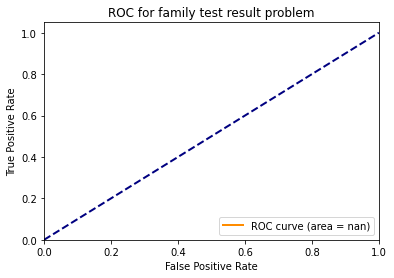

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

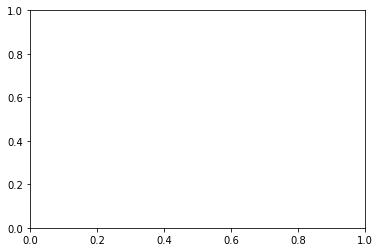

In [287]:
avg_roc=[]
for k in range(8):
    YF_missing=MissingData[k][0]
    #calculate y_missing:
    Y=np.zeros((n,T))
    for i in range(n):
        for j in range(YF_missing.shape[0]):
            if unique_rows[j,i]==1:
                Y[i,:]=YF_missing[j,:]
    Trained=[]
    for time_step in range(10,360,10):
        G_=G[:time_step]
        Y_=Y[:,:time_step]
        X_=X[:,:time_step]
        #Train=Gibbs_train(hyper_params,G_,F,Y_,U,K,J)
        Train=Gibbs(params,X_,G_,F,Y_,1,1)
        Trained.append(Train)
    roc_=[]
    for i in range(1,len(Trained)):
        Train=np.array(Trained[i][2][0])
        y_score=np.hstack(Train)
        y_test=np.hstack(X_true[:,:Train.shape[1]])
    
        roc_.append(plot_ROC(y_score,y_test))
    plt.plot(range(10,360,10),roc_)
    avg_roc.append([mu,np.mean(np.array(roc_))])

In [205]:
YF_missing=MissingData[0][0]

In [206]:
#calculate y_missing:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF_missing[j,:]


In [259]:
Trained=[]
for time_step in range(10,100,20):
    G_=G[:time_step]
    Y_=Y[:,:time_step]
    X_=X[:,:time_step]
    #Train=Gibbs_train(hyper_params,G_,F,Y_,U,K,J)
    Train=Gibbs(params,X_,G_,F,Y_,1,1)
    Trained.append(Train)

Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 22:18:53
0 0
Current Time is : 22:18:53
1 0
Current Time is : 22:18:55
2 0
Current Time is : 22:18:56
3 0
Current Time is : 22:18:58
4 0
Current Time is : 22:19:00
5 0
Current Time is : 22:19:01
6 0
Current Time is : 22:19:02
7 0
Current Time is : 22:19:04
8 0
Current Time is : 22:19:05
9 0
Current Time is : 22:19:06
Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 22:19:07
0 0
Current Time is : 22:19:07
1 0
Current Time is : 22:19:11
2 0
Current Time is : 22:19:15
3 0
Current Time is : 22:19:18
4 0
Current Time is : 22:19:22
5 0
Current Time is : 22:19:26
6 0
Current Time is : 22:19:30
7 0
Current Time is : 22:19:34
8 0
Current Time is : 22:19:38
9 0
Current Time is : 22:19:42
10 0
Current Time is : 22:19:46
11 0
Current Time is : 22:19:5

73 0
Current Time is : 08:57:44
74 0
Current Time is : 08:57:56
75 0
Current Time is : 08:58:08
76 0
Current Time is : 08:58:19
77 0
Current Time is : 08:58:30
78 0
Current Time is : 08:58:42
79 0
Current Time is : 08:58:54
80 0
Current Time is : 08:59:05
81 0
Current Time is : 08:59:17
82 0
Current Time is : 08:59:29
83 0
Current Time is : 08:59:40
84 0
Current Time is : 09:27:23
85 0
Current Time is : 09:27:36
86 0
Current Time is : 09:27:47
87 0
Current Time is : 09:27:58
88 0
Current Time is : 09:28:08
89 0
Current Time is : 09:28:18


In [232]:
Trained[0][1].shape[1]

100

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


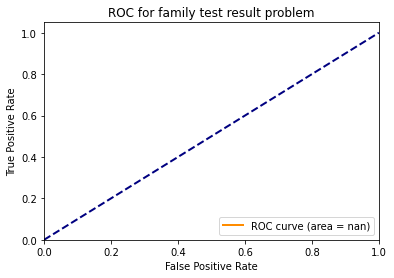

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

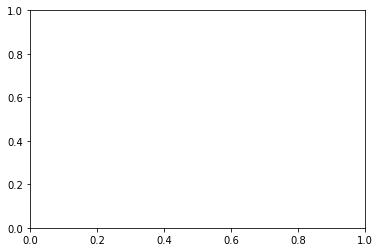

In [276]:
roc_=[]
for i in range(1,len(Trained)):
    Train=np.array(Trained[i][2][0])
    y_score=np.hstack(Train)
    y_test=np.hstack(X_true[:,:Train.shape[1]])
    
    roc_.append(plot_ROC(y_score,y_test))
plt.plot(range(20,100,20),roc_)

In [272]:
len(roc_)

1

In [256]:
YF_missing=MissingData[0][1]

In [257]:
#calculate y_missing:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF_missing[j,:]


TypeError: 'int' object is not subscriptable

In [258]:
Trained=[]
for time_step in range(10,100,20):
    G_=G[:time_step]
    Y_=Y[:,:time_step]
    X_=X[:,:time_step]
    #Train=Gibbs_train(hyper_params,G_,F,Y_,U,K,J)
    Train=Gibbs(params,X_,G_,F,Y_,1,1)
    Trained.append(Train)

Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 16:53:10
0 0
Current Time is : 16:53:10
1 0
Current Time is : 16:53:11
2 0
Current Time is : 16:53:13
3 0
Current Time is : 16:53:14
4 0
Current Time is : 16:53:15
5 0
Current Time is : 16:53:17
6 0
Current Time is : 16:53:18
7 0
Current Time is : 16:53:19
8 0
Current Time is : 16:53:21
9 0
Current Time is : 16:53:22
Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 16:53:23
0 0
Current Time is : 16:53:23
1 0
Current Time is : 16:53:27
2 0
Current Time is : 16:53:30
3 0
Current Time is : 16:53:34
4 0
Current Time is : 16:53:38
5 0
Current Time is : 16:53:41
6 0
Current Time is : 16:53:45
7 0
Current Time is : 16:53:48
8 0
Current Time is : 16:53:52
9 0
Current Time is : 16:53:56
10 0
Current Time is : 16:54:00
11 0
Current Time is : 16:54:0

73 0
Current Time is : 17:30:29
74 0
Current Time is : 17:30:42
75 0
Current Time is : 17:30:54
76 0
Current Time is : 17:31:08


KeyboardInterrupt: 

In [278]:
Trained[0][1].shape[1]

100

In [261]:
len 

0.45457756362401225

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


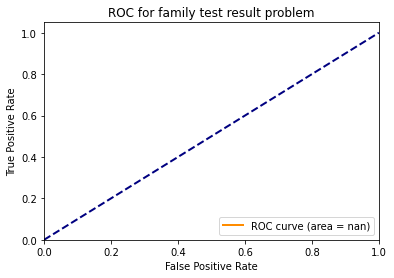

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

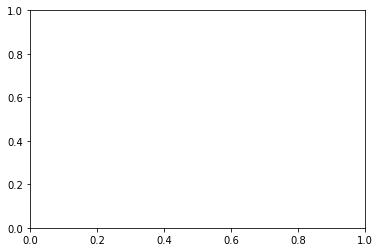

In [279]:
roc_=[]
avg_roc=[]
for i in range(1,len(Trained)):
    Train=np.array(Trained[i][2][0])
    y_score=np.hstack(Train)
    y_test=np.hstack(X_true[:,:Train.shape[1]])
    
    roc_.append(plot_ROC(y_score,y_test))
plt.plot(range(20,100,20),roc_)
avg_roc.append([mu,np.mean(np.array(roc_))])
print(avg_roc)

In [224]:
def plot_ROC(y_score,y_test):
    plt.figure()
    lw = 2
    #y_score=np.hstack(Train[2][j])
    #y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

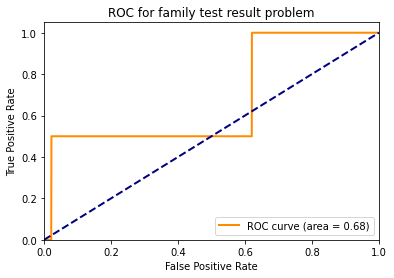

0.6788692461641095

In [223]:
plot_ROC(y_score,y_test)

In [ ]:
trained_params=Train[0]
%store trained_params

In [ ]:
Test=Gibbs_test(trained_params,T,n,G,F,Y,K,J)

In [ ]:
print("alpha,beta,betaf,gama,t0,t1,n,T,K,J,U",Train[0],n,T,K,J,U)

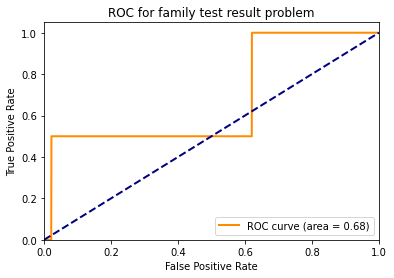

In [219]:
plt.figure()
lw = 2
for j in range(J):
    #y_score=np.hstack(Train[2][j])
    #y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def show_TPR_by_time(X_true,X_score,T):
    TP,FN,TPR=np.zeros((T)),np.zeros((T)),np.zeros((T))
    for t in range(T):
        TP[t]=np.count_nonzero(np.multiply(X_true,X_score).T[t]==1)
        FN[t]=np.count_nonzero((X_true-2*X_score).T[t]==1)
        if (TP[t]+FN[t])!=0:
            TPR[t]=TP[t]/(TP[t]+FN[t])
        #print(TP[t],FN[t])
        #plt.plot(t,TPR[t],'go--', linewidth=2, markersize=1)  
    plt.plot(range(T),TPR) 
    plt.show() 

In [ ]:
show_TPR_by_time(X,Train[2][0],T)

In [ ]:
plt.figure()
lw = 2
for j in range(J):
    y_score=np.hstack(Train[2][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF[j,:]

In [ ]:
K,U,J=2,2,2

In [ ]:
# function to add noise to observation vector, in order to test the model performance:
def add_noise(YF,noise_percent):
    number_of_families=YF.shape[0]
    YF_noisey=np.copy(YF)
    index=random.sample(range(0,number_of_families*T ), int(number_of_families*T*noise_percent))
    for j in index:
        i=int(j/T)
        t=j-i*T
        YF_noisey[i,t]=(1+YF[i,t])*(1-YF[i,t])
    return YF_noisey 

In [ ]:
noise_percent=.1
YF_noisey=add_noise(YF,noise_percent)

In [ ]:
trained_params=Train[0]

In [ ]:
Y_noisey=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y_noisey[i,:]=YF_noisey[j,:]

In [ ]:
# Main code to run entire Gibbs sampling algorithm U times:
def Gibbs_test(param,T,n,G,F,Y,K,J):
    
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    theta_0_=param[4]
    thata_1_=param[5] 
    prob=[]  
    XX=[]
    for j in range(J):
        
        print(params)
        X=Forward_Sampling(T,n,G,F,params)
        print("Forward_Sampling",j,"\n","\n",X)
        print("Start Gibbs Sampling:")
        cal=Calculate_X(K,T,X,G,F,Y,params)
        X=cal[0]
        pos_probs=cal[1]
        prob.append(pos_probs)        
        XX.append(X)    
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
    winsound.Beep(freq, duration) 
    return np.array(XX),np.array(prob)

In [ ]:
Test=Gibbs_test(trained_params,T,n,G,F,Y_noisey,K,J)

In [ ]:
plt.figure()
lw = 2
for j in range(J):
    y_score=np.hstack(Test[1][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plt.figure()
lw = 2
for j in range(J):
    y_score=np.hstack(Train[2][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Save true value of X in Z, as the correct label of data:
Z=X
np.sum(Z)

In [ ]:
F=Family

# Adding noise to YF:

In [ ]:
%store YF
%store params

In [ ]:
noise_percent=.1
YF_noisey=add_noise(YF,noise_percent,unique_rows)

In [ ]:
U=10
K=10
J=10

In [ ]:
# Main code to run entire Gibbs algorithm U times:
Zflat = np.hstack(Z)
XX=[]
for j in range(J):
    params=initialize_parameters(a_alpha,b_alpha,a_beta,b_beta,a_betaf,b_betaf,a_gama,b_gama,a_teta0,b_teta0,a_teta1,b_teta1)
    #params=np.array([0.019 , 0.0118, 0.0841, 0.173 , 0.014 , 0.97  ])
    X=Forward_Sampling(T,n,G,F,params)
    #X=Z
    print("Forward_Sampling",j,"\n","\n",X)
    print("Start Gibbs Sampling:")
    mylist=[]
    accuracy=[]
    for i in range(U):
        print("************************************************ Iteration",i,"************************************************")
        print("Current Parameters:",params)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        X=Calculate_X(Z,K,T,X,G,F,Y,params)
        prm=Params(R,G,F,X,n,T,Y,params)
        params=prm[0]
        R=prm[1]
        Xflat = np.hstack(X)
    #result = 1 - spatial.distance.cosine(Zflat, Xflat)
        result=accuracy_score(Xflat, Zflat,normalize=True)
        print("Accuracy:",result)
        accuracy.append(result)
    XX.append(X)    
    myList = list(range(U))
    iteration=np.array(myList)
    Accuracy=np.array(accuracy)
    label="Sample:"+str(j)
    plt.figure()
    plt.plot(iteration,Accuracy,label=label ) 
    plt.legend()
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time is :", current_time)
winsound.Beep(freq, duration) 

In [ ]:
def estimate_Y(Family,X,params):
    theta_0=params[4]
    theta_1=params[5]
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None)
    return YF